Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [101]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
print('tf.__version__:%s' % (tf.__version__))
from six.moves import cPickle as pickle
from six.moves import range

# my imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, time
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grid
from rpy2.robjects.lib import ggplot2
import rpy2.robjects.pandas2ri

tf.__version__:0.6.0


/usr/local/lib/python2.7/site-packages/rpy2/robjects/lib/ggplot2.py:59: UserWarning: This was designed againt ggplot2 version 2.0.0 but you have 2.1.0
  warnings.warn('This was designed againt ggplot2 version %s but you have %s' % (TARGET_VERSION, ggplot2.__version__))


In [2]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  glbObsFitX = save['train_dataset']
  glbObsFitY = save['train_labels' ]
  glbObsOOBX = save['valid_dataset']
  glbObsOOBY = save['valid_labels' ]
  glbObsNewX = save['test_dataset' ]
  glbObsNewY = save['test_labels'  ]
  del save  # hint to help gc free up memory
  print('Training   set', glbObsFitX.shape, glbObsFitY.shape)
  print('Validation set', glbObsOOBX.shape, glbObsOOBY.shape)
  print('Test       set', glbObsNewX.shape, glbObsNewY.shape)

('Training   set', (519114, 28, 28), (519114,))
('Validation set', (10000, 28, 28), (10000,))
('Test       set', (18724, 28, 28), (18724,))


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
glbObsFitX, glbObsFitY = reformat(glbObsFitX, glbObsFitY)
glbObsOOBX, glbObsOOBY = reformat(glbObsOOBX, glbObsOOBY)
glbObsNewX, glbObsNewY = reformat(glbObsNewX, glbObsNewY)
print('Fit set', glbObsFitX.shape, glbObsFitY.shape)
print('OOB set', glbObsOOBX.shape, glbObsOOBY.shape)
print('New set', glbObsNewX.shape, glbObsNewY.shape)

('Fit set', (519114, 28, 28, 1), (519114, 10))
('OOB set', (10000, 28, 28, 1), (10000, 10))
('New set', (18724, 28, 28, 1), (18724, 10))


In [4]:
def accuracy(predictions, labels):
  return (1.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

N = nObs              
dim(X) = N, image_size, image_size, num_channels  
dim(Lyr1Wgt) = patch_size, patch_size, num_channels, depth  
dim(Lyr1Bss) = depth  
Lyr1 = relu(conv2d(X   , Lyr1Wgt, stride) + Lyr1Bss)  
dim(Lyr1) = N, image_size // stride, image_size // stride, depth  

dim(Lyr2Wgt) = patch_size, patch_size, depth, depth  
dim(Lyr2Bss) = depth  
Lyr2 = relu(conv2d(Lyr1, Lyr2Wgt, stride) + Lyr2Bss)  
dim(Lyr2) = N, image_size // (stride * stride), image_size // (stride * stride), depth  

Lyr2Reshaped = reshape(Lyr2)  
dim(Lyr2Reshaped) = N,  
                 (image_size // (stride * stride)) * (image_size // (stride * stride)) * depth  
                 
dim(Lyr3Wgt) = (image_size // (stride * stride)) * (image_size // (stride * stride)) * depth ,  
                num_hidden  
dim(Lyr3Bss) = num_hidden  
Lyr3 = relu(matmul(Lyr2Reshaped, Lyr3Wgt) + Lyr3Bss)  
dim(Lyr3) = N, num_hidden  

dim(Lyr4Wgt) = num_hidden, num_labels  
dim(Lyr4Bss) = num_labels  
Lyr4 = matmul(Lyr3, Lyr4Wgt) + Lyr4Bss  
dim(Lyr4) = N, num_labels  

Y = Lyr4  
dim(Y) = N, num_labels  

In [95]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

def fitMdlNSteps(nSteps, verbose = False):
    print('\nfitNSteps: nSteps:%4d; ' % ( \
            nSteps))
    
    startTm = datetime.now()

    mdlDf = pd.DataFrame({'nSteps': [nSteps]
                         })
    tfGraph = tf.Graph()

    with tfGraph.as_default():

      # Input data.
      tfObsFitX = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tfObsFitY = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tfObsOOBX = tf.constant(glbObsOOBX)
      tfObsNewX = tf.constant(glbObsNewX)

      # Variables.
      tf.set_random_seed(123)  
      tfLyr1Wgt = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, num_channels, depth], stddev=0.1))
      tfLyr1Bss = tf.Variable(tf.zeros([depth]))
      tfLyr2Wgt = tf.Variable(tf.truncated_normal(
          [patch_size, patch_size, depth, depth], stddev=0.1))
      tfLyr2Bss = tf.Variable(tf.constant(1.0, shape=[depth]))
      tfLyr3Wgt = tf.Variable(tf.truncated_normal(
          [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
      tfLyr3Bss = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
      tfLyr4Wgt = tf.Variable(tf.truncated_normal(
          [num_hidden, num_labels], stddev=0.1))
      tfLyr4Bss = tf.Variable(tf.constant(1.0, shape=[num_labels]))
        
#       print('  tfLyr1:')  
#       print(tfLyr1Wgt.initialized_value())
#       print(tfLyr1Bss.initialized_value())          

      # Model.
      def model(data, verbose = False):
        if (verbose):    
            print('             X.shape:%s' % (     data.get_shape().as_list()))
            print('       Lyr1Wgt.shape:%s' % (tfLyr1Wgt.get_shape().as_list()))
            print('       Lyr1Bss.shape:%s' % (tfLyr1Bss.get_shape().as_list()))        
        conv = tf.nn.conv2d(data, tfLyr1Wgt, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + tfLyr1Bss)
        if (verbose):        
            print('          Lyr1.shape:%s' % (   hidden.get_shape().as_list()))
        
        if (verbose):        
            print('       Lyr2Wgt.shape:%s' % (tfLyr2Wgt.get_shape().as_list()))
            print('       Lyr2Bss.shape:%s' % (tfLyr2Bss.get_shape().as_list()))        
        conv = tf.nn.conv2d(hidden, tfLyr2Wgt, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + tfLyr2Bss)
        if (verbose):        
            print('          Lyr2.shape:%s' % (   hidden.get_shape().as_list()))        
        
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        if (verbose):        
            print('  Lyr2Reshaped.shape:%s' % (  reshape.get_shape().as_list()))
            print('       Lyr3Wgt.shape:%s' % (tfLyr3Wgt.get_shape().as_list()))
            print('       Lyr3Bss.shape:%s' % (tfLyr3Bss.get_shape().as_list()))                
        hidden = tf.nn.relu(tf.matmul(reshape, tfLyr3Wgt) + tfLyr3Bss)
        lyr3 = hidden
        if (verbose):        
            print('          Lyr3.shape:%s' % (     lyr3.get_shape().as_list()))        
        
        if (verbose):        
            print('       Lyr4Wgt.shape:%s' % (tfLyr4Wgt.get_shape().as_list()))
            print('       Lyr4Bss.shape:%s' % (tfLyr4Bss.get_shape().as_list()))
        retVal = tf.matmul(hidden, tfLyr4Wgt) + tfLyr4Bss
        if (verbose):        
            print('          Lyr4.shape:%s' % (   retVal.get_shape().as_list()))        
        
        return(retVal, lyr3)

      # Training computation.
      logitsFit, lyr3Fit = model(tfObsFitX)
      tfLoss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logitsFit, tfObsFitY))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(tfLoss)

      # Predictions for the training, validation, and test data.
      tfObsFitYP = tf.nn.softmax(logitsFit)
      logitsOOB, lyr3OOB = model(tfObsOOBX, verbose)        
      tfObsOOBYP = tf.nn.softmax(logitsOOB)
      logitsNew, lyr3New = model(tfObsNewX)        
      tfObsNewYP = tf.nn.softmax(logitsNew)
        
    with tf.Session(graph = tfGraph) as session:
      #tf.set_random_seed(127)        
      tf.initialize_all_variables().run()
      print('  Initialized')
      for step in range(nSteps):
        offset = (step * batch_size) % (glbObsFitY.shape[0] - batch_size)
        tfObsBchX = glbObsFitX[offset:(offset + batch_size), :, :, :]
        tfObsBchY = glbObsFitY[offset:(offset + batch_size), :]
        feed_dict = {tfObsFitX : tfObsBchX, tfObsFitY : tfObsBchY}
        #tf.set_random_seed(131)        
        tfSsnOptimizer, tfSsnLoss, tfSsnObsFitYP = session.run(
          [optimizer, tfLoss, tfObsFitYP], feed_dict = feed_dict)
        if (step % 500 == 0):
          print('    Minibatch tfLoss at step %4d: %.4f' % (step, tfSsnLoss))
          print('      tfObsBch accuracy: %.4f' % accuracy(tfSsnObsFitYP    ,  tfObsBchY))
          print('      tfObsOOB accuracy: %.4f' % accuracy(tfObsOOBYP.eval(), glbObsOOBY))
      
      print("  Optimized")
#       mdlDf['tfLyr1Wgt'] = np.array2string(tfLyr1Wgt.eval(), 
#                                         formatter = {'float_kind':lambda x: '%.4f' % x})
#       print('  tfLyr1Wgt:'); print(tfLyr1Wgt.eval())
      retObsOOBLyr3 =    lyr3OOB.eval()        
      retObsOOBYP   = tfObsOOBYP.eval()
      mdlDf['OOBAccuracy'] = accuracy(tfObsOOBYP.eval(), glbObsOOBY)        
      print('  OOB accuracy: %.4f' % (mdlDf['OOBAccuracy'][0]))
      mdlDf['NewAccuracy'] = accuracy(tfObsNewYP.eval(), glbObsNewY)        
      print('  New accuracy: %.4f' % (mdlDf['NewAccuracy'][0]))
      mdlDf['elapsedSecs'] = (datetime.now() - startTm).seconds  
      print('  elapsed: %.2d seconds' % (mdlDf['elapsedSecs'][0]))  
    
    return(mdlDf, retObsOOBYP, retObsOOBLyr3)

In [94]:
nSteps = 1001
mdlDf, selObsOOBYP, selObsOOBLyr3 = fitMdlNSteps(nSteps = nSteps, verbose = True)
print(mdlDf)


fitNSteps: nSteps:1001; 
             X.shape:[10000, 28, 28, 1]
       Lyr1Wgt.shape:[5, 5, 1, 16]
       Lyr1Bss.shape:[16]
          Lyr1.shape:[10000, 14, 14, 16]
       Lyr2Wgt.shape:[5, 5, 16, 16]
       Lyr2Bss.shape:[16]
          Lyr2.shape:[10000, 7, 7, 16]
  Lyr2Reshaped.shape:[10000, 784]
       Lyr3Wgt.shape:[784, 64]
       Lyr3Bss.shape:[64]
          Lyr3.shape:[10000, 64]
       Lyr4Wgt.shape:[64, 10]
       Lyr4Bss.shape:[10]
          Lyr4.shape:[10000, 10]
  Initialized
    Minibatch tfLoss at step    0: 3.1047
      tfObsBch accuracy: 0.1250
      tfObsOOB accuracy: 0.1036
    Minibatch tfLoss at step  500: 0.8841
      tfObsBch accuracy: 0.6875
      tfObsOOB accuracy: 0.8004
    Minibatch tfLoss at step 1000: 0.6604
      tfObsBch accuracy: 0.7500
      tfObsOOB accuracy: 0.8306
  Optimized
  OOB accuracy: 0.8306
  New accuracy: 0.8965
elapsed: 48 seconds
   nSteps  OOBAccuracy  NewAccuracy  elapsedSecs
0    1001       0.8306     0.896496           48


In [96]:
#glbMdlDf = mdlDf

In [97]:
nStepsSearch  = [1001, 2001, 3001, 4001]
#nStepsSearch  = [bslMdlParams.nSteps]

for nSteps in nStepsSearch:
    if (glbMdlDf.shape[0] == 0) or \
       (glbMdlDf[(glbMdlDf.nSteps == nSteps )].shape[0] == 0):
        mdlDf, selObsOOBYP, selObsOOBLyr3 = fitMdlNSteps(nSteps = nSteps, verbose = False)
        glbMdlDf = glbMdlDf.append(mdlDf)    


fitNSteps: nSteps:2001; 
  Initialized
    Minibatch tfLoss at step    0: 3.1047
      tfObsBch accuracy: 0.1250
      tfObsOOB accuracy: 0.1036
    Minibatch tfLoss at step  500: 0.8841
      tfObsBch accuracy: 0.6875
      tfObsOOB accuracy: 0.8004
    Minibatch tfLoss at step 1000: 0.6604
      tfObsBch accuracy: 0.7500
      tfObsOOB accuracy: 0.8306
    Minibatch tfLoss at step 1500: 0.3417
      tfObsBch accuracy: 0.8125
      tfObsOOB accuracy: 0.8423
    Minibatch tfLoss at step 2000: 1.1228
      tfObsBch accuracy: 0.7500
      tfObsOOB accuracy: 0.8451
  Optimized
  OOB accuracy: 0.8451
  New accuracy: 0.9134
  elapsed: 72 seconds

fitNSteps: nSteps:3001; 
  Initialized
    Minibatch tfLoss at step    0: 3.1047
      tfObsBch accuracy: 0.1250
      tfObsOOB accuracy: 0.1036
    Minibatch tfLoss at step  500: 0.8841
      tfObsBch accuracy: 0.6875
      tfObsOOB accuracy: 0.8004
    Minibatch tfLoss at step 1000: 0.6604
      tfObsBch accuracy: 0.7500
      tfObsOOB accuracy:

In [98]:
glbMdlDf = (glbMdlDf
            .set_index(['nSteps'], 
                       drop = False)
            .sort_values('OOBAccuracy')
            )
#print(glbMdlDf[['OOBAccuracy', 'NewAccuracy']].sort('OOBAccuracy'))
print(glbMdlDf)

        nSteps  OOBAccuracy  NewAccuracy  elapsedSecs
nSteps                                               
1001      1001       0.8306     0.896496           48
2001      2001       0.8451     0.913427           72
3001      3001       0.8612     0.926351          120
4001      4001       0.8667     0.929876          126


In [99]:
pickle_file = '4_convolutions_glbMdlDf.pickle'
#glbMdlDf.iloc[:, 0:7].to_pickle(pickle_file)

if 'tfGraph' in glbMdlDf.columns:
    glbMdlDf.drop('tfGraph', axis = 1).to_pickle(pickle_file)
else:    
    glbMdlDf.to_pickle(pickle_file)

In [102]:
robjects.pandas2ri.activate()
glbMdlRDf = robjects.conversion.py2ri(glbMdlDf)
print(glbMdlRDf)

     nSteps OOBAccuracy NewAccuracy elapsedSecs
1001   1001      0.8306   0.8964965          48
2001   2001      0.8451   0.9134266          72
3001   3001      0.8612   0.9263512         120
4001   4001      0.8667   0.9298761         126



In [103]:
pltNStepsFn = robjects.r("""
    require(ggplot2)
    require(tidyr)
    require(grid)
    
    multiplot <- function(..., plotlist=NULL, cols) {
        require(grid)

        # Make a list from the ... arguments and plotlist
        plots <- c(list(...), plotlist)

        numPlots = length(plots)

        # Make the panel
        plotCols = cols                          # Number of columns of plots
        plotRows = ceiling(numPlots/plotCols) # Number of rows needed, calculated from # of cols

        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(plotRows, plotCols)))
        vplayout <- function(x, y)
            viewport(layout.pos.row = x, layout.pos.col = y)

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            curRow = ceiling(i/plotCols)
            curCol = (i-1) %% plotCols + 1
            print(plots[[i]], vp = vplayout(curRow, curCol ))
        }

    }
    
    function(df) {
        bstDf <- tidyr::gather(df[which.max(df$OOBAccuracy), ], 'key', 'value', 
                                -nSteps)
        pltLst <- list()
        print("nSteps: ")
        print(sort(unique(df$nSteps)))

#         for (num_steps in sort(unique(df$num_steps))) 
#             for (learnDecayRate in sort(unique(df$learnDecayRate))) 
#                 for (kpRELUs in sort(unique(df$kpRELUs))) {        
                    pltDf <- tidyr::gather(df[
#                                    (df$num_steps      == num_steps     ) & 
#                                    (df$learnDecayRate == learnDecayRate) & 
#                                    (df$kpRELUs        == kpRELUs       )
                                              , ], 'key', 'value', 
                                            -nSteps)
                    #print(nrow(pltDf))
                    if (nrow(pltDf) > 0) {
                        #print(pltDf)
                        #tfSsnLoss OOBAccuracy
                        gp <- ggplot(pltDf, 
                                    aes_string(x = 'nSteps', y = 'value'
                                                # group for lines
                                                #, group = 'nRELUs'
                                                )) + 
                            #geom_line(aes(color = as.factor(nRELUs))) +
                            # hline if x-axis has log scale & x = 0 value needs to be highlighted
#                             geom_hline(data = subset(pltDf, (l2Penalty1 == 0)), 
#                                         aes(yintercept = value, color = as.factor(nRELUs)), 
#                                         linetype = 'dashed') + 
                            geom_point(data = bstDf[(bstDf$key == 'OOBAccuracy'), ],
                                        shape = 5, color = 'black', size = 3) +             
                            #scale_x_log10() + 
                            ylab('') +
                            scale_linetype_identity(guide = "legend") + 
                            #guides(linetype = "legend") + 
                            #facet_grid('key ~ l2Penalty3', labeller = label_both, scales = 'free_y') + 
                            theme(legend.position = "bottom") +
                            ggtitle(sprintf('Convolution Neural Net: '))
                        pltLst[[1]] <- gp    
#                         pltLst[[paste(as.character(num_steps), 
#                                       as.character(learnDecayRate), 
#                                       as.character(kpRELUs), 
#                                       sep = '#')]] <- gp    
                    }        
#         }        
         
        png(filename = '4_convolutions_mdlNSteps.png', 
            width = 480 * 1, height = 480 * 1)
        multiplot(plotlist = pltLst, cols = 1)
        dev.off()
    }
""")

pltNStepsFn(glbMdlRDf)

[1] "nSteps: "
[1] 1001 2001 3001 4001


/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: tidyr

  res = super(Function, self).__call__(*new_args, **new_kwargs)


<IntVector - Python:0x1804b27a0 / R:0x7feb69aedc68>
[       1]

In [70]:
print('glbObsOOB accuracy: %.4f' % accuracy(selObsOOBYP, glbObsOOBY))
print(type(selObsOOBYP))
print(selObsOOBYP.shape)
print(type(selObsOOBLyr3))
print(selObsOOBLyr3.shape)

glbObsOOB accuracy: 0.8306
<type 'numpy.ndarray'>
(10000, 10)
<type 'numpy.ndarray'>
(10000, 64)


#### What do the selected model's layers identify ?

In [71]:
# True +ves vs. False +ves
selObsOOBYDf = pd.DataFrame()
selObsOOBYDf['imgIx'] = range(glbObsOOBY.shape[0])
selObsOOBYDf['labelY'] = np.argmax(glbObsOOBY, axis = 1)
selObsOOBYDf['labelYP'] = np.argmax(selObsOOBYP, axis = 1)
selObsOOBYDf['labelYPAcc'] = selObsOOBYDf['labelY'] == selObsOOBYDf['labelYP']
selObsOOBYDf['labelYPProb'] = np.max(selObsOOBYP, axis = 1)
print(selObsOOBYDf['labelYPAcc'].value_counts())
print(selObsOOBYDf[selObsOOBYDf['labelYPAcc'] == True ][:5])
print(selObsOOBYDf[selObsOOBYDf['labelYPAcc'] == False][:5])

True     8306
False    1694
Name: labelYPAcc, dtype: int64
   imgIx  labelY  labelYP labelYPAcc  labelYPProb
0      0       7        7       True     0.967098
1      1       7        7       True     0.870261
2      2       6        6       True     0.927733
3      3       7        7       True     0.978583
4      4       7        7       True     0.999115
    imgIx  labelY  labelYP labelYPAcc  labelYPProb
16     16       1        9      False     0.877981
18     18       3        1      False     0.251560
19     19       4        2      False     0.734680
23     23       8        9      False     0.237222
28     28       3        0      False     0.149524



Label: 0
  imgIx: 5262
  selObsOOBYDf.iloc[imgIx]:
imgIx             5262
labelY               0
labelYP              0
labelYPAcc        True
labelYPProb    0.99997
Name: 5262, dtype: object


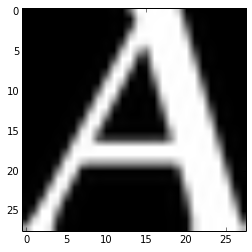

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


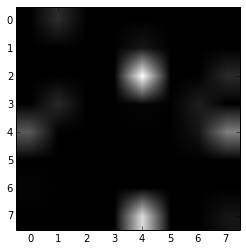

  imgIx: 8573
  selObsOOBYDf.iloc[imgIx]:
imgIx              8573
labelY                7
labelYP               0
labelYPAcc        False
labelYPProb    0.995931
Name: 8573, dtype: object


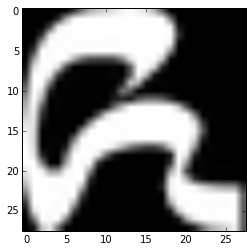

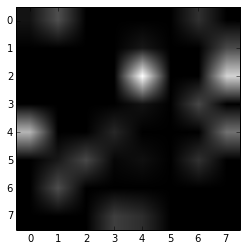


Label: 1
  imgIx: 3628
  selObsOOBYDf.iloc[imgIx]:
imgIx              3628
labelY                1
labelYP               1
labelYPAcc         True
labelYPProb    0.999286
Name: 3628, dtype: object


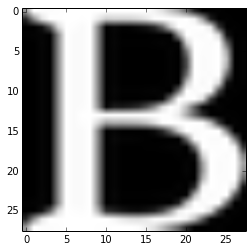

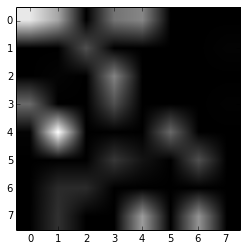

  imgIx: 6384
  selObsOOBYDf.iloc[imgIx]:
imgIx              6384
labelY                3
labelYP               1
labelYPAcc        False
labelYPProb    0.985627
Name: 6384, dtype: object


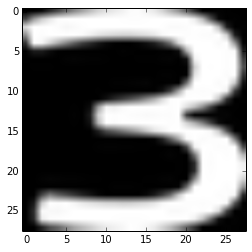

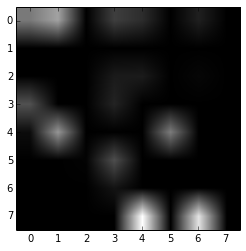


Label: 2
  imgIx: 8688
  selObsOOBYDf.iloc[imgIx]:
imgIx              8688
labelY                2
labelYP               2
labelYPAcc         True
labelYPProb    0.999278
Name: 8688, dtype: object


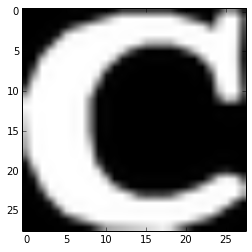

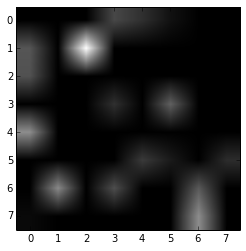

  imgIx: 5908
  selObsOOBYDf.iloc[imgIx]:
imgIx              5908
labelY                8
labelYP               2
labelYPAcc        False
labelYPProb    0.972574
Name: 5908, dtype: object


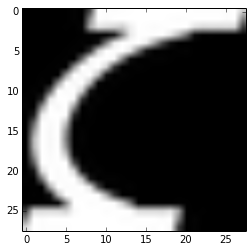

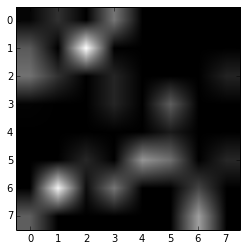


Label: 3
  imgIx: 9918
  selObsOOBYDf.iloc[imgIx]:
imgIx              9918
labelY                3
labelYP               3
labelYPAcc         True
labelYPProb    0.996875
Name: 9918, dtype: object


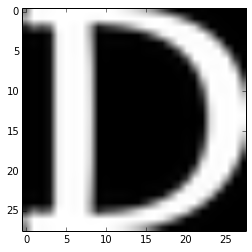

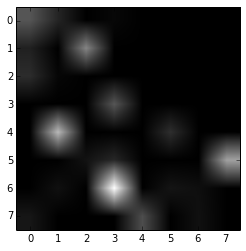

  imgIx: 4315
  selObsOOBYDf.iloc[imgIx]:
imgIx              4315
labelY                1
labelYP               3
labelYPAcc        False
labelYPProb    0.933755
Name: 4315, dtype: object


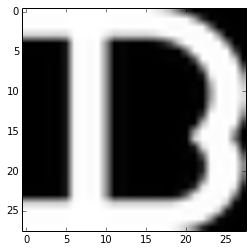

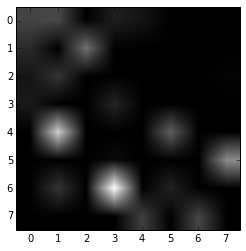


Label: 4
  imgIx: 5483
  selObsOOBYDf.iloc[imgIx]:
imgIx              5483
labelY                4
labelYP               4
labelYPAcc         True
labelYPProb    0.999408
Name: 5483, dtype: object


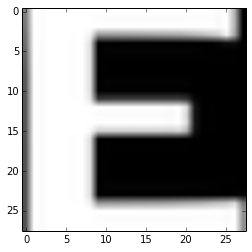

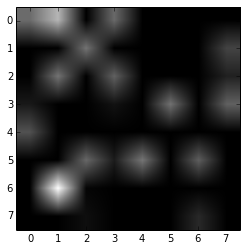

  imgIx: 3989
  selObsOOBYDf.iloc[imgIx]:
imgIx              3989
labelY                7
labelYP               4
labelYPAcc        False
labelYPProb    0.993613
Name: 3989, dtype: object


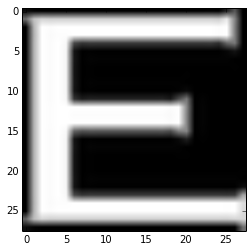

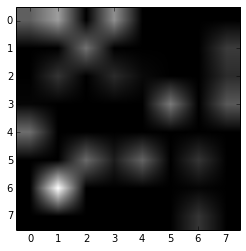


Label: 5
  imgIx: 2094
  selObsOOBYDf.iloc[imgIx]:
imgIx              2094
labelY                5
labelYP               5
labelYPAcc         True
labelYPProb    0.999888
Name: 2094, dtype: object


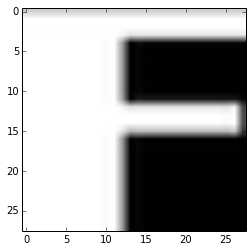

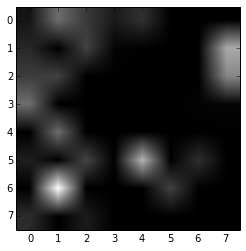

  imgIx: 2168
  selObsOOBYDf.iloc[imgIx]:
imgIx              2168
labelY                9
labelYP               5
labelYPAcc        False
labelYPProb    0.996836
Name: 2168, dtype: object


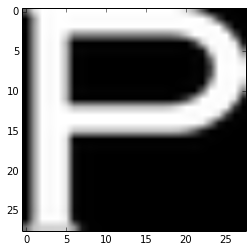

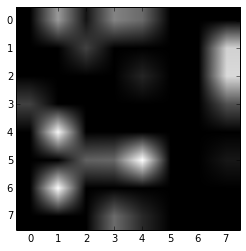


Label: 6
  imgIx: 7194
  selObsOOBYDf.iloc[imgIx]:
imgIx              7194
labelY                6
labelYP               6
labelYPAcc         True
labelYPProb    0.999973
Name: 7194, dtype: object


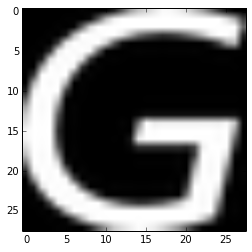

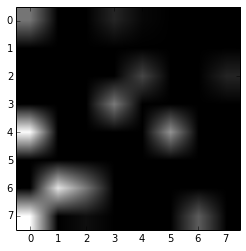

  imgIx: 2620
  selObsOOBYDf.iloc[imgIx]:
imgIx              2620
labelY                2
labelYP               6
labelYPAcc        False
labelYPProb    0.999302
Name: 2620, dtype: object


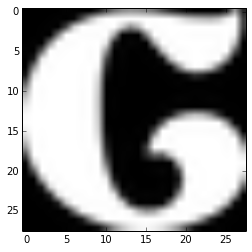

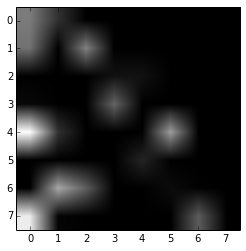


Label: 7
  imgIx: 3696
  selObsOOBYDf.iloc[imgIx]:
imgIx              3696
labelY                7
labelYP               7
labelYPAcc         True
labelYPProb    0.999482
Name: 3696, dtype: object


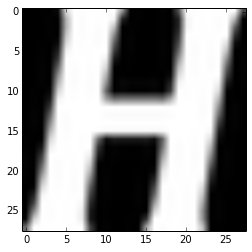

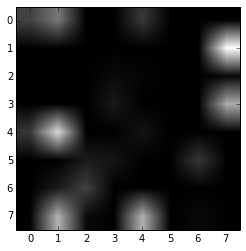

  imgIx:  836
  selObsOOBYDf.iloc[imgIx]:
imgIx               836
labelY                0
labelYP               7
labelYPAcc        False
labelYPProb    0.974413
Name: 836, dtype: object


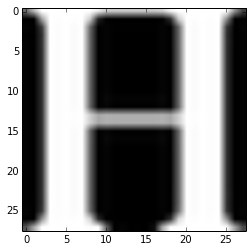

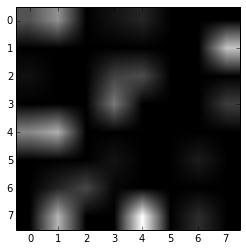


Label: 8
  imgIx:  511
  selObsOOBYDf.iloc[imgIx]:
imgIx               511
labelY                8
labelYP               8
labelYPAcc         True
labelYPProb    0.998377
Name: 511, dtype: object


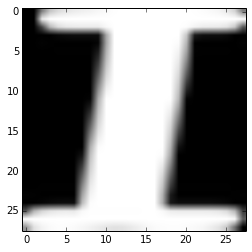

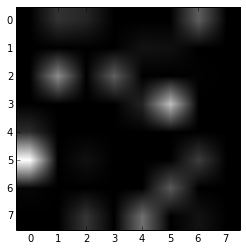

  imgIx: 6524
  selObsOOBYDf.iloc[imgIx]:
imgIx              6524
labelY                0
labelYP               8
labelYPAcc        False
labelYPProb    0.977745
Name: 6524, dtype: object


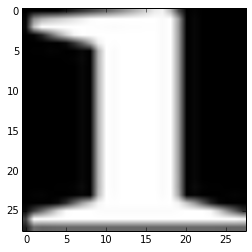

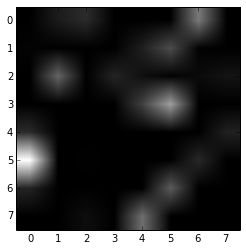


Label: 9
  imgIx: 9815
  selObsOOBYDf.iloc[imgIx]:
imgIx              9815
labelY                9
labelYP               9
labelYPAcc         True
labelYPProb    0.999649
Name: 9815, dtype: object


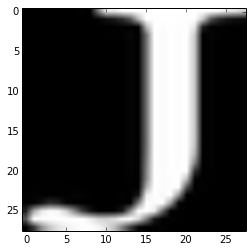

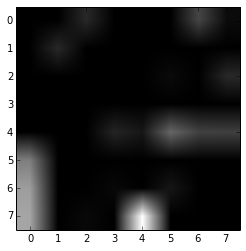

  imgIx: 7263
  selObsOOBYDf.iloc[imgIx]:
imgIx              7263
labelY                0
labelYP               9
labelYPAcc        False
labelYPProb    0.976087
Name: 7263, dtype: object


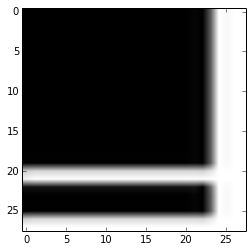

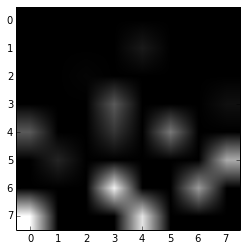

In [82]:
for label in xrange(num_labels):
#for label in xrange(1):    
    print("\nLabel:%2d" % (label))
#     imgIx = glbObsOOBYDf[(glbObsOOBYDf['labelYPAcc'] == True ) &
#                          (glbObsOOBYDf['labelYP'] == label)]['labelYPProb'].argmax()
    for imgIx in [selObsOOBYDf[(selObsOOBYDf['labelYPAcc'] == True ) &
                               (selObsOOBYDf['labelYP'] == label)]['labelYPProb'].argmax(),
                  selObsOOBYDf[(selObsOOBYDf['labelYPAcc'] == False) &
                               (selObsOOBYDf['labelYP'] == label)]['labelYPProb'].argmax()]:
        print("  imgIx:%5d" % (imgIx))
        print("  selObsOOBYDf.iloc[imgIx]:" % ())
        print(selObsOOBYDf.iloc[imgIx])
#         print("  glbObsOOBX[imgIx, :].shape:%s" % (str(glbObsOOBX[imgIx, :].shape)))        
#         print("  glbObsOOBX[imgIx, :5, :5, :]:%s"% (glbObsOOBX[imgIx, :5, :5, :]))
        img2DArr = glbObsOOBX[imgIx, :].reshape((glbObsOOBX[imgIx, :].shape[0], \
                                                 glbObsOOBX[imgIx, :].shape[1]))
#         print("  img2DArr[:5, :5]:"% ())
#         print(img2DArr[:5, :5])
        plt.figure
        plt.imshow(img2DArr, cmap = plt.cm.gray)
        plt.show()

        #print(selObsOOBLyr3[imgIx, :].shape)
        img2DArr = selObsOOBLyr3[imgIx, :].reshape((selObsOOBLyr3[imgIx, :].shape[0] ** 0.5, \
                                                    selObsOOBLyr3[imgIx, :].shape[0] ** 0.5))
        plt.figure
        plt.imshow(img2DArr, cmap = plt.cm.gray)
        plt.show()

In [91]:
from datetime import datetime, time
startTm = datetime.now()
print('elapsed: %.2d seconds' % (datetime.now() - startTm).seconds)

elapsed: 00 seconds


---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---